# Raman Challenge Dataset Analysis

This notebook analyzes the dig-4-bio-raman transfer learning challenge
dataset and demonstrates how to load and work with the multi-instrument
Raman spectroscopy data.

In [17]:
from pathlib import Path

from typing import Literal
import numpy as np
import pandas as pd
import plotly.express as px
import ramanspy as rp

import warnings

warnings.filterwarnings("ignore", category=SyntaxWarning)

In [18]:
"""
Define common paths and preprocessing pipelines.

This section sets up:
- Data directory path
- Standard preprocessing pipeline (without normalization)
  - Cropping to fingerprint region (300-1942 cm⁻¹)
  - Cosmic ray removal (Whitaker-Hayes)
  - Denoising (Savitzky-Golay filter)
  - Baseline correction (ASPLS)
  
Note: Normalization is commented out as it can destroy concentration information
for regression tasks.
"""

# Data directory path
data_path = Path("../data/dig-4-bio-raman-transfer-learning-challenge")

# Fingerprint region
MIN_WAVENUMBER = 300
MAX_WAVENUMBER = 1942

# Standard preprocessing pipeline without normalization
# This pipeline is suitable for regression tasks where we want to preserve
# concentration-related intensity information
standard_pipeline_without_normalisation = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(MIN_WAVENUMBER, MAX_WAVENUMBER)),  # Fingerprint region
    rp.preprocessing.despike.WhitakerHayes(),          # Remove cosmic rays
    rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),  # Smooth noise
    rp.preprocessing.baseline.ASPLS(),                 # Remove baseline drift
    # rp.preprocessing.normalise.MinMax()  # Excluded for regression tasks
])

In [19]:
"""
Utility functions
"""

def find_spectral_columns(df: pd.DataFrame) -> tuple[list[str], list[str], np.ndarray]:
    """
    Identifies spectral data columns by checking if the column name can be converted to a float.
    This is a robust way to separate metadata from spectral data.
    """
    spectral_cols = []
    metadata_cols = []
    for col in df.columns:
        try:
            float(col)
            spectral_cols.append(col)
        except (ValueError, TypeError):
            metadata_cols.append(col)

    wavenumbers = pd.to_numeric(spectral_cols)
    return metadata_cols, spectral_cols, wavenumbers


def build_background_subtraction_pipeline(background: rp.Spectrum) -> rp.preprocessing.Pipeline:
    """
    Builds a background subtraction pipeline with a specified region for cropping.
    """
    background = rp.preprocessing.misc.Cropper(region=(MIN_WAVENUMBER, MAX_WAVENUMBER)).apply(background)
    return rp.preprocessing.Pipeline([
        rp.preprocessing.misc.Cropper(region=(MIN_WAVENUMBER, MAX_WAVENUMBER)),
        rp.preprocessing.misc.BackgroundSubtractor(background=background)
    ])

### Dataset Description

This dataset contains Raman spectra from **8 different instruments**
measuring samples with known concentrations of three analytes:

-   **Glucose** (g/L)
-   **Sodium Acetate** (Na_acetate, g/L)
-   **Magnesium Sulfate** (Mg_SO4, g/L)

The instruments included are: Anton 532, Anton 785, Kaiser, Metrohm,
Mettler Toledo, Tec 5, Timegate, and Tornado.

**Measurement Protocol:**

-   All samples were measured at room temperature with
    instrument-specific exposure times
-   Most instruments acquired 5 replicate spectra per sample; Kaiser and
    Timegate recorded a single spectrum per sample
-   Due to varying instrument availability, the sample sets differ
    across spectrometers

**Instrument Characteristics:** Each instrument exhibits unique
properties that must be accounted for in analysis:

-   **Wavenumber ranges**: Vary from ~200 to ~3500 cm⁻¹ across
    instruments
-   **Spectral resolution**: Differs between instruments

Let’s start by loading data from one instrument (anton_532) to
understand the data structure and visualize a sample spectrum.

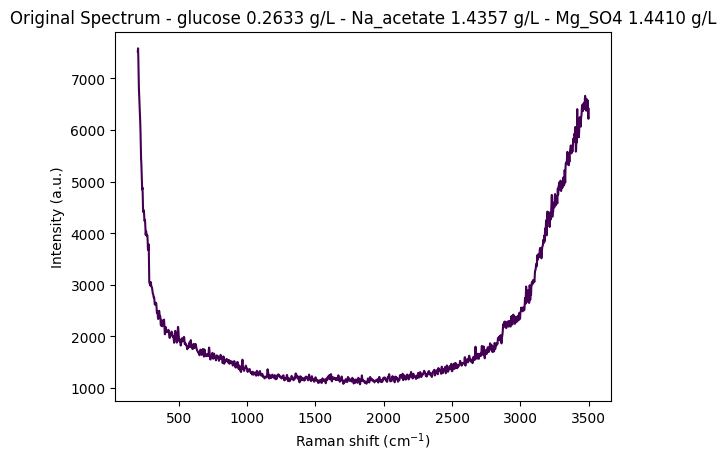

In [20]:
"""
Load and visualize a sample spectrum from the anton_532 instrument.

This demonstrates:
1. Loading CSV data with spectral columns (wavenumbers) and metadata
2. Separating spectral data from metadata
3. Creating a RamanSPy SpectralContainer for analysis
4. Visualizing a raw spectrum with its concentration information
"""

# Load data from anton_532 instrument
df = pd.read_csv(data_path / "anton_532.csv").drop(columns=["MSM_present", "fold_idx"])

# Separate spectral columns (numeric column names = wavenumbers) from metadata
metadata_cols, spectral_cols, wavenumbers = find_spectral_columns(df)

# Create RamanSPy SpectralContainer for easier manipulation
spectral_container = rp.SpectralContainer(
    spectral_data=df[spectral_cols].values,
    spectral_axis=wavenumbers
)

# Select first spectrum for visualization
spectrum = spectral_container[0]
metadata = df[metadata_cols].iloc[0].to_dict()

# Create informative title with concentration information
title = (
    f"Original Spectrum - "
    f"glucose {metadata['glucose']:.4f} g/L - "
    f"Na_acetate {metadata['Na_acetate']:.4f} g/L - "
    f"Mg_SO4 {metadata['Mg_SO4']:.4f} g/L"
)

# Plot the spectrum
rp.plot.spectra(spectra=[spectrum], plot_type="single", title=title)
rp.plot.show()

### Data Structure Overview

Let’s examine the structure of the loaded dataset to understand how the
data is organized. The DataFrame contains:

-   **Metadata columns**: Concentration values (glucose, Na_acetate,
    Mg_SO4) and other sample information
-   **Spectral columns**: Numeric column names representing wavenumber
    values (cm⁻¹)
-   Each row represents a single spectrum measurement with its
    associated concentration metadata

In [21]:
# Display the first few rows of the dataset
df.head(5)

5 rows × 1654 columns

### Step-by-Step Preprocessing Visualization

Preprocessing is crucial for Raman spectroscopy data analysis. Raw
spectra contain:

-   **Baseline drift**: Broad fluorescence background
-   **Cosmic rays**: Sharp spikes from detector artifacts
-   **Noise**: Random measurement noise
-   **Edge effects**: Instrument-specific artifacts at spectral edges

This section visualizes how each preprocessing step transforms the
spectrum, helping us understand the impact of each operation. We apply
the following steps:

-   **Cropping**: Remove edge artifacts and focus on fingerprint region
    (300-1942 cm⁻¹)
-   **Cosmic Ray Removal**: Remove sharp spikes (Whitaker-Hayes
    algorithm)
-   **Denoising**: Smooth the spectrum (Savitzky-Golay filter)
-   **Baseline Correction**: Remove broad fluorescence background
    (ASPLS)

This visualization helps understand how each preprocessing step improves
signal quality and prepares the data for analysis.

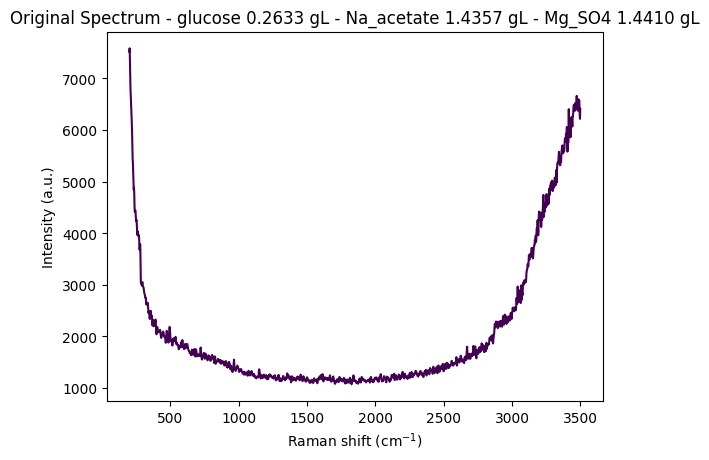

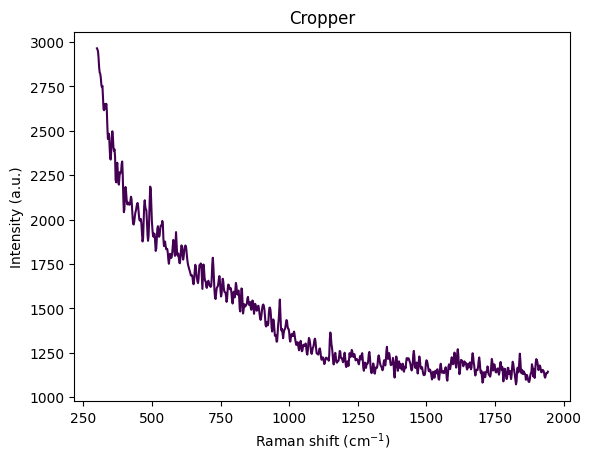

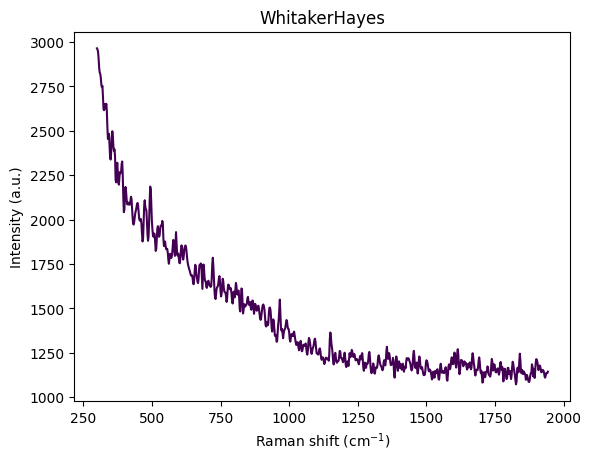

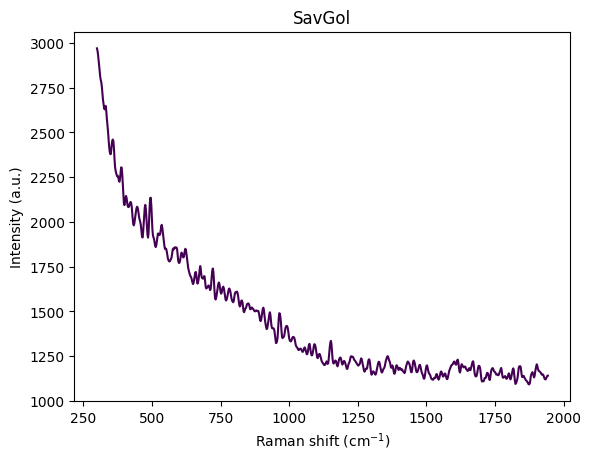

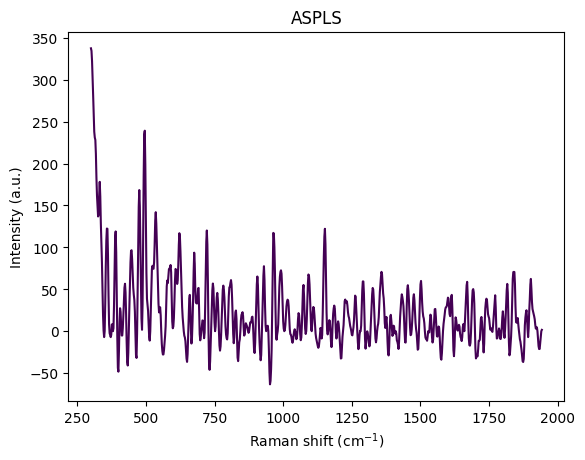

In [22]:
df = pd.read_csv(data_path / "anton_532.csv").drop( columns=["MSM_present", "fold_idx"])
metadata_cols, spectral_cols, wavenumbers = find_spectral_columns(df)
spectral_container = rp.SpectralContainer(
    spectral_data=df[spectral_cols].values,
    spectral_axis=wavenumbers
)
spectrum = spectral_container[0]
metadata = df[metadata_cols].iloc[0].to_dict()
title = f"Original Spectrum - glucose {metadata['glucose']:.4f} gL - Na_acetate {metadata['Na_acetate']:.4f} gL - Mg_SO4 {metadata['Mg_SO4']:.4f} gL"
rp.plot.spectra(spectra=[spectrum], plot_type="single", title=title)
rp.plot.show()
for step in standard_pipeline_without_normalisation:
    spectrum = step.apply(spectrum)
    title = f"{step.__class__.__name__}"
    rp.plot.spectra([spectrum], plot_type="single", title=title)
    rp.plot.show()

### Understanding Spectral Cropping

From the visualization above, we can observe:

-   **Wavenumber range**: Approximately 300–3600 cm⁻¹
-   **Strong baseline/fluorescence**: Broad curvature from background
    fluorescence
-   **Edge artifacts**:
    -   Below ~450 cm⁻¹: Edge effects, Rayleigh tail, optical artifacts
    -   Above ~3000 cm⁻¹: OH stretch from water dominates the signal
-   **Chemically informative region**: The fingerprint region (400–1800
    cm⁻¹) contains the most relevant information

The reference paper [Comparing machine learning methods on Raman spectra
from eight different
spectrometers](https://doi.org/10.1016/j.saa.2025.125861) recommends:

-   **Crop to 300–1942 cm⁻¹**: The largest common range across all 8
    instruments
-   **Rationale**:
    -   Preserves glucose, acetate, and MgSO₄ peaks
    -   Removes high-wavenumber water OH stretch
    -   Eliminates instrument-specific edge artifacts
    -   Improves cross-device robustness for transfer learning

For this dataset, cropping to **300–1942 cm⁻¹** is justified because:

-   **Glucose peaks**: ~800–1150 cm⁻¹ ✓
-   **Acetate peak**: ~920 cm⁻¹ ✓
-   **MgSO₄ strong peak**: ~980 cm⁻¹ ✓
-   **Minimal water interference**: Removes dominant OH stretch region
-   **Better signal-to-noise**: Focuses on chemically informative region

This region contains the most relevant information for quantitative
analysis while removing noise and artifacts.

### Sample Structure and Organization

The dataset is organized around **unique concentration triplets**
defined by the three analytes:

-   **Glucose** (g/L)
-   **Sodium Acetate** (Na_acetate, g/L)
-   **Magnesium Sulfate** (Mg_SO4, g/L)

**Replication Structure:**

-   Most instruments (Anton 532, Anton 785, Metrohm, Mettler Toledo, Tec
    5, Tornado) recorded **at least 5 replicate spectra** per unique
    concentration triplet
-   **Kaiser and Timegate instruments** recorded only **1 spectrum per
    concentration triplet** (no replicates)

**Sample Numbering:** To facilitate analysis and visualization, we
assign a unique `sample_number` to each distinct concentration triplet.
This allows us to:

-   Group spectra by their concentration profile
-   Select representative spectra from each unique sample
-   Track how preprocessing affects spectra from the same sample across
    different replicates

### Exploring Concentration Distribution

Let’s examine the distribution of unique concentration triplets in the
dataset. This helps us understand:

-   How many unique samples (concentration combinations) are present
-   The frequency of each concentration triplet
-   The overall structure of the experimental design

In [23]:
df_metadata = df[metadata_cols]
df_metadata[["glucose", "Na_acetate", "Mg_SO4"]].value_counts()

glucose   Na_acetate  Mg_SO4  
0.00000   0.00000     0.000000    10
                      0.022899     5
                      1.483750     5
                      3.490220     5
          0.01612     0.005016     5
          0.38593     0.023827     5
          0.65286     0.046091     5
          0.71544     1.567450     5
          0.75931     0.017697     5
          0.76773     3.945410     5
          1.29106     0.000000     5
          1.37442     1.355800     5
          1.39750     3.308900     5
0.24955   0.08245     3.454390     5
0.25369   0.00000     0.022609     5
0.25636   0.67294     0.005511     5
0.25649   0.74089     3.345560     5
0.25787   0.00000     0.000000     5
0.26229   0.03709     1.494600     5
0.26335   1.43570     1.441010     5
0.27710   0.69733     1.441180     5
0.28256   1.33788     0.035751     5
0.29784   1.56128     3.348590     5
0.49945   1.33009     0.003688     5
0.51645   1.02701     1.328620     5
0.52096   0.00000     0.015037     5
0.52616

### Assigning Sample Numbers

To facilitate analysis, we assign a unique `sample_number` to each
distinct concentration triplet. This allows us to:

-   Group all replicate spectra from the same sample together
-   Easily select representative spectra for visualization
-   Track samples across different preprocessing steps

After assignment, we sort the DataFrame by `sample_number` to organize
the data for easier analysis.

In [24]:
df['sample_number'] = df.groupby(['glucose', 'Na_acetate', 'Mg_SO4']).ngroup()

In [25]:
df = df.sort_values(by="sample_number")
df

270 rows × 1655 columns

## Comparing Preprocessing Pipelines: Standard vs. Background Subtraction

This section visualizes the effects of different preprocessing pipelines
on Raman spectra from various concentrations. We compare two
preprocessing approaches:

1.  **Standard Pipeline**: Applies cropping, cosmic ray removal,
    denoising, and baseline correction
2.  **Background Subtraction Pipeline**: Crops the spectrum and
    subtracts a reference background spectrum

**Key Objectives:**

-   Understand how different preprocessing methods affect spectral
    appearance
-   Compare pipeline performance on spectra from different
    concentrations
-   Assess pipeline behavior on replicate spectra from the same
    concentration

**Expected Observations:**

-   **Background Subtraction Pipeline**: When applied to spectra from
    different concentrations, this pipeline produces distinct spectral
    profiles that clearly differentiate between concentration levels.
    This demonstrates that the method effectively preserves
    concentration-dependent signal differences.

-   **Standard Pipeline**: In contrast, the standard pipeline tends to
    produce more similar-looking spectra across different
    concentrations, as it focuses on removing artifacts and noise while
    preserving the overall spectral shape. This can be beneficial for
    certain types of analysis but may reduce concentration-dependent
    signal differences.

**Important Note:** The background subtraction pipeline uses the first
spectrum in the dataset as the reference background. For spectra from
the same sample (same concentration), this is the first replicate. For
spectra from different samples (different concentrations), this
corresponds to the first sample in the dataset, which is the zero
concentration sample.

In [26]:
# Note: Required for exporting static images in Quarto documents.
# (Comment out these lines to enable interactive Plotly plots in Jupyter or other interactive environments.)
import plotly.io as pio
pio.renderers.default = 'png'

def plot_spectra_interactive(
    df: pd.DataFrame,
    pipeline_type: Literal["standard", "background"] = "standard",
    samples_type: Literal["same", "different"] = "same",
    height: int = 800,
) -> None:
    metadata_cols, spectral_cols, wavenumbers = find_spectral_columns(df)
    spectral_container = rp.SpectralContainer(
        spectral_data=df[spectral_cols].values,
        spectral_axis=wavenumbers,
    )

    fig_title = f"Plot of {pipeline_type} pipeline with {samples_type} samples"

    match pipeline_type:
        case "standard":
            spectra_list = standard_pipeline_without_normalisation.apply(spectral_container)
        case "background":
            spectra_list = build_background_subtraction_pipeline(background=spectral_container[0]).apply(spectral_container)

    # Series labels
    match samples_type:
        case "same":
            series_labels = list(range(len(df)))
        case "different":
            series_labels = df[["glucose", "Na_acetate", "Mg_SO4"]].apply(lambda x: f"glucose {x['glucose']:.2f} gL - Na_acetate {x['Na_acetate']:.2f} gL - Mg_SO4 {x['Mg_SO4']:.2f} gL", axis=1).tolist()

    all_spectra_dfs = []
    for i, spectrum in enumerate(spectra_list):
        temp_df = pd.DataFrame({
            'Wavenumber': spectrum.spectral_axis,
            'Intensity': spectrum.spectral_data
        })
        temp_df['Series'] = series_labels[i]
        all_spectra_dfs.append(temp_df)

    # Combine all the small DataFrames into one large, tidy DataFrame
    plot_df = pd.concat(all_spectra_dfs, ignore_index=True)

    # Create the interactive plot
    fig = px.line(
        plot_df,
        x='Wavenumber',
        y='Intensity',
        color='Series',          # Each series gets a different color line
        title=fig_title,
        labels={                 # Custom labels for axes
            "Wavenumber": "Wavenumber (cm⁻¹)",
            "Intensity": "Intensity (a.u.)"
        },
        template='plotly_white',  # A clean template with grids
        height=height,
    )

    # Update subplot titles to be cleaner (optional)
    # fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

    # Display the figure in the Jupyter Notebook
    fig.show()

### Comparing Pipelines on Different Concentrations

We first examine how each preprocessing pipeline handles spectra from
**different concentration levels**. This helps us understand:

-   How well each pipeline preserves concentration-dependent spectral
    features
-   The ability to distinguish between different analyte concentrations
-   The impact of preprocessing on quantitative signal information

We select one representative spectrum from each unique concentration
triplet to compare the pipelines on distinct samples.

In [27]:
different_samples_df = (
    df.groupby("sample_number", as_index=False)
    .nth(0)
)
different_samples_df.head(5)

5 rows × 1655 columns

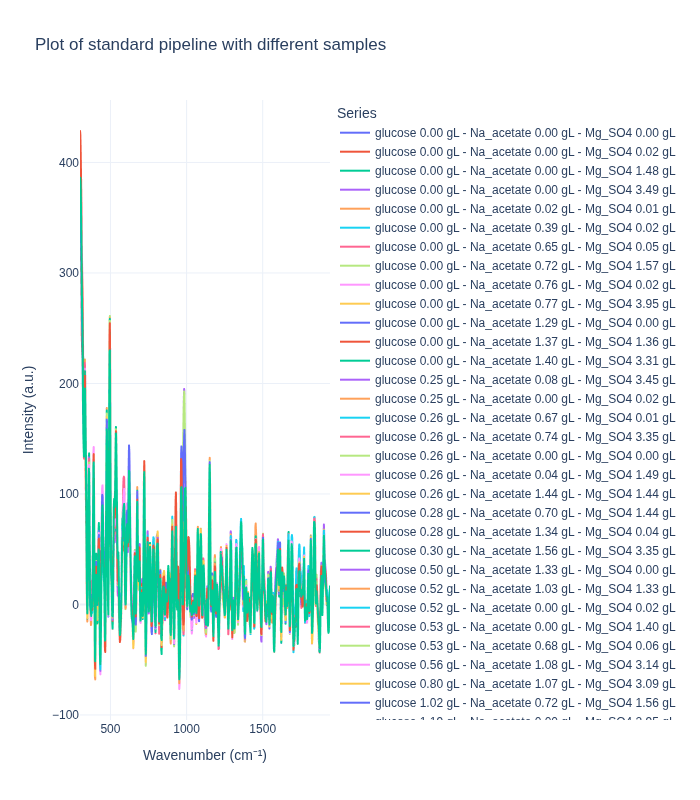

In [28]:
plot_spectra_interactive(df=different_samples_df, pipeline_type="standard", samples_type="different")

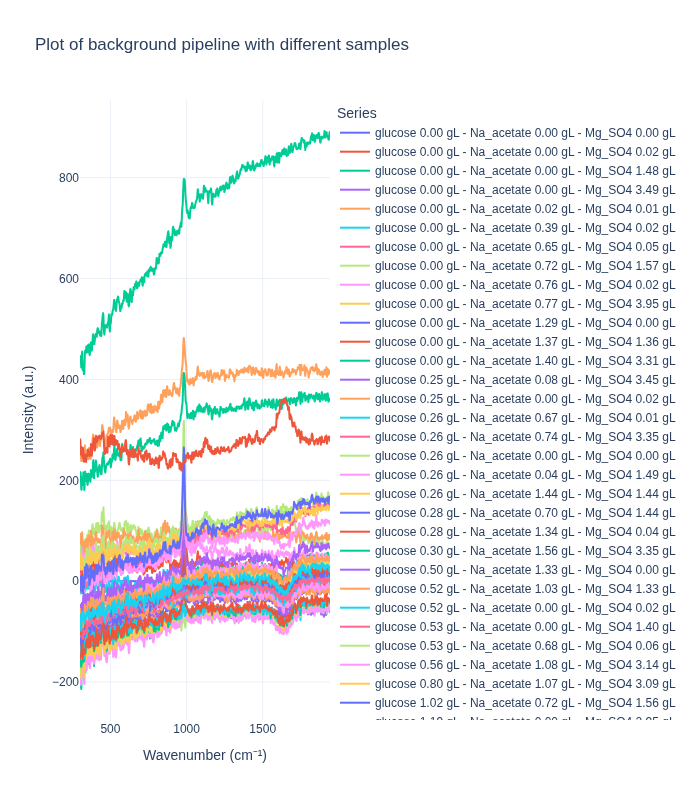

In [29]:
plot_spectra_interactive(df=different_samples_df, pipeline_type="background", samples_type="different")

### Comparing Pipelines on Replicate Spectra

Next, we examine how each preprocessing pipeline handles **replicate
spectra from the same concentration**. This analysis reveals:

-   **Measurement reproducibility**: How consistent are replicate
    measurements after preprocessing?
-   **Noise characteristics**: What residual variability remains after
    preprocessing?
-   **Pipeline stability**: How do different preprocessing methods
    affect replicate consistency?

We randomly select one sample (concentration triplet) and visualize all
its replicate spectra to assess within-sample variability.

In [30]:
# Draw a random sample number
unique_sample_numbers = df["sample_number"].unique()
random_sample_number = np.random.choice(unique_sample_numbers)
same_samples_df = df[df["sample_number"] == random_sample_number]
same_samples_df


5 rows × 1655 columns

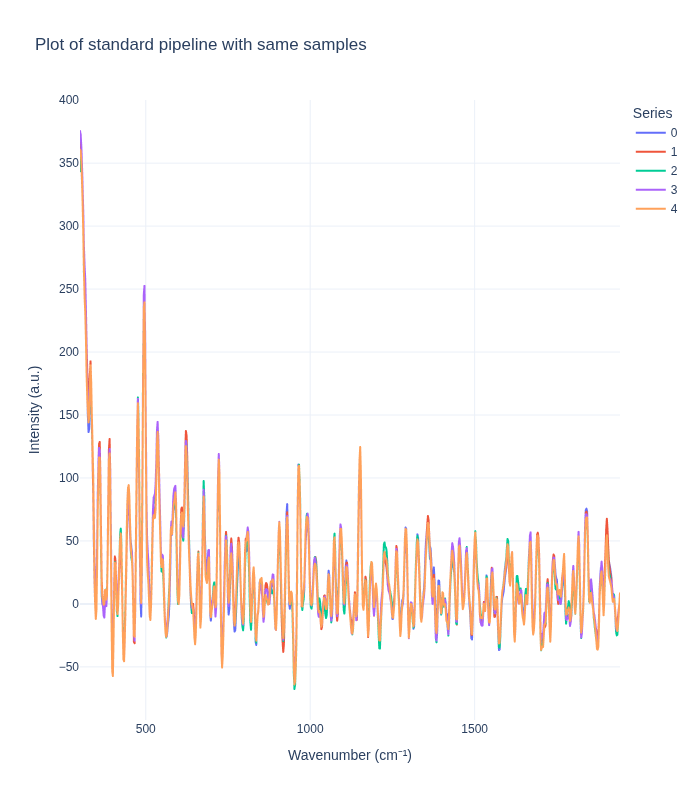

In [31]:
plot_spectra_interactive(df=same_samples_df, pipeline_type="standard", samples_type="same")

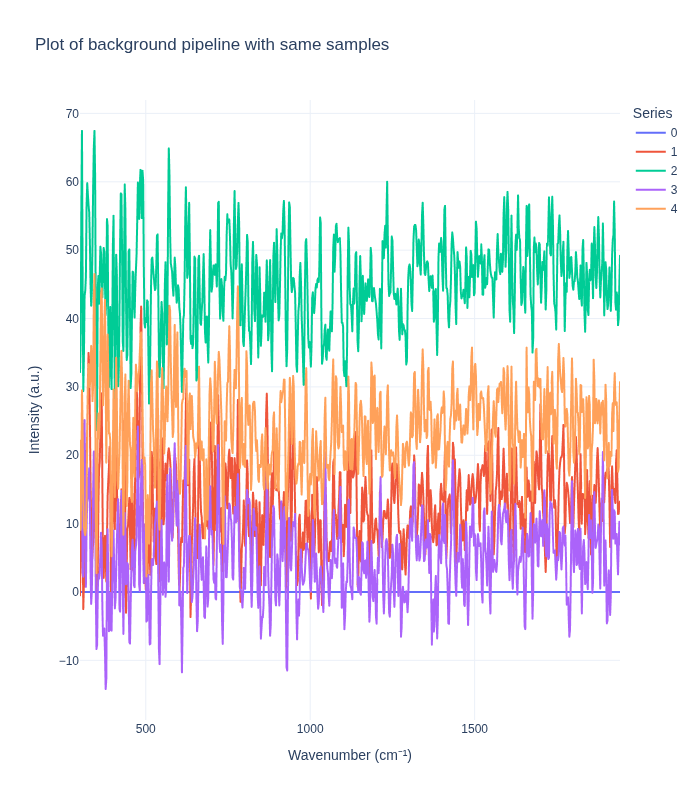

In [32]:
plot_spectra_interactive(df=same_samples_df, pipeline_type="background", samples_type="same")

### Understanding Measurement Variability

The visualization above reveals important insights about measurement
variability:

**Key Observations:**

1.  **Intrinsic Experimental Variability**: Even with identical sample
    concentrations, replicate spectra show some variation. This
    reflects:
    -   Natural measurement noise inherent in Raman spectroscopy
    -   Slight variations in sample positioning or laser focus
    -   Instrument-specific measurement characteristics
    -   Environmental factors (temperature, humidity, etc.)
2.  **Pipeline Impact on Variability**:
    -   The **standard pipeline** typically reduces variability by
        removing noise and artifacts, making replicates appear more
        similar
    -   The **background subtraction pipeline** may preserve or even
        amplify certain types of variability, depending on the reference
        background used
3.  **Implications for Analysis**:
    -   Understanding this variability is crucial for setting
        appropriate model expectations
    -   The residual variability after preprocessing represents the
        lower bound of prediction uncertainty
    -   This information helps in designing robust models that can
        handle real-world measurement conditions

This variability analysis is essential for developing reliable
quantitative models that can generalize to new measurements.